# Face Recognition -Model1

1. 使用MTCNN進行人臉偵測
2. 使用自建CNN模型進行人臉辨識
3. 使用kaggle5位日本明星資料集
4. 進行靜態圖像辨識

In [ ]:
# !pip install --user mtcnn
# !pip install --user matplotlib
# !pip install --user pandas
# !pip install --user sklearn
# !pip install --user opencv-python

In [1]:
# 將警告訊息關掉
import warnings
warnings.filterwarnings('ignore')

#Utilities相關函式庫
import os
import sys

# 圖像處理函示庫
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# 數值處理函式庫
import pandas as pd
import numpy as np

# 機器學習函式庫
from sklearn.model_selection import train_test_split

# 深度學習函式庫
import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop, Adam, SGD
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

# 人臉偵測函式庫
from mtcnn import MTCNN
detector = MTCNN()

# 相關參數設定
picture_size = 224
batch_size = 8  # 一次用多少筆資料更新模型
num_classes = 5  # 資料集有幾個類別
epochs = 200      # 訓練迭代次數
save_dir = os.path.join(os.getcwd(), 'saved_models') # 儲存模型的路徑
model_name = 'Model3_VGG19_V2, trained_model.h5' # 模型名稱



Using TensorFlow backend.


In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 資料集目錄
DATA_PATH = os.path.join(ROOT_DIR, 'Data')

# 訓練/驗證的圖像資料目錄
TRAIN_IMGS_PATH = os.path.join(DATA_PATH, 'training_set')
TEST_IMGS_PATH = os.path.join(DATA_PATH, 'testing_set')

In [ ]:
# 載入分類的 Label
# 用來對訓練資料即進行分類
dict_Category = {}
classmap = pd.read_csv('./Data/classmap.csv', header = None)

for idx, label in classmap.iterrows():
    dict_Category[label[0]] = label[1]
dict_Category

In [ ]:
# 對訓練資料集進行類別 Label
TrainDirectory = TRAIN_IMGS_PATH
labelnames = os.listdir(TrainDirectory) # 列出有幾個要分類的人, 每個人的圖像放在一個資料集，因此五人則是五個資料集
total_img=[]
total_label=[]
print(labelnames)

for labelname in labelnames:
    imageList,labelList = load_data(TrainDirectory+'/'+labelname+'/',dict_Category[labelname])
    total_img = total_img + imageList;
    total_label = total_label+labelList;
    print(labelname,'-'*3,len(imageList))

total_img=np.asarray(total_img)

# 對 label進行 OneHotEncoding
labelnames = keras.utils.to_categorical(total_label,len(labelnames))    


In [ ]:
def load_data(path,label):
    imageList = []
    labelList = []
    imgs = os.listdir(path)
    
    for imgname in imgs:
        if(imgname[-4:] == ".png"):
            img = cv2.imread(path+ imgname, cv2.IMREAD_COLOR)                                                                                                                                                                                                                                        
            print(path+ imgname)
#             img = cv2.resize(img, (picture_size, picture_size))
#             img = img[:,:,::-1]
            image_count, crop = face_location(img)
            
#             crop = crop.astype(np.float32)
#             crop = preprocess_input(img)
            
            imageList.append(crop)
            labelList.append(label)#類別0
            print("照片共辨識出 {} 張臉。".format(image_count))
            
    return imageList,labelList

In [3]:
# 直接讀取處理好的檔案
total_img_resized = np.load('total_crop_resized.npy')
labelnames = np.load('labelnames.npy')

In [4]:
# 切分訓練/測試資料
#train_x = total_img
#train_y = labelnames

train_x,test_x, train_y, test_y = train_test_split(total_img_resized,
                                                  labelnames,
                                                test_size = 0.1,stratify= labelnames)#random_state = 123,
print('train:',train_x.shape,'test:',test_x.shape)

# 正規化資料
# 標準化0~255的值到0~1
x_train_normalize = train_x.astype('float32') / 255.0
x_test_normalize = test_x.astype('float32') / 255.0

train: (403, 224, 224, 3) test: (45, 224, 224, 3)


In [5]:
# 建立CNN模型
# CNN層
model = Sequential()

model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = x_train_normalize.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(128, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(256, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.25))




# DNN層
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
___________________________

In [6]:
# 訓練模型
optimizer = Adam(lr=3e-6,decay=0.0001,beta_1=0.99,beta_2=0.999) #100e-6
model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

In [7]:
# Data Augmentation
datagen  = ImageDataGenerator(
            rotation_range = 30,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            horizontal_flip = True, 
            vertical_flip = False,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest')

In [8]:
# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1) # patience=10為連續10次模型loss沒再下降就停止

# Fit model
aug_ratio = 2
steps_per_epoch = int(aug_ratio * train_x.shape[0] / batch_size)
validation_steps = int(aug_ratio * test_x.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(x_train_normalize, train_y, batch_size = batch_size),
                                   epochs = epochs,
                                   validation_data = (x_test_normalize, test_y),
                                   callbacks = [checkpoint, earlystop],
                                   steps_per_epoch=steps_per_epoch,
                                   validation_steps=validation_steps
                                   )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
100/100 [==============================] - 20s 196ms/step - loss: 1.6092 - acc: 0.2175 - val_loss: 1.6088 - val_acc: 0.2222

Epoch 00001: val_loss improved from inf to 1.60876, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model3_VGG19_V2, trained_model.h5
Epoch 2/200
100/100 [==============================] - 12s 123ms/step - loss: 1.6077 - acc: 0.2304 - val_loss: 1.6062 - val_acc: 0.2222

Epoch 00002: val_loss improved from 1.60876 to 1.60623, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model3_VGG19_V2, trained_model.h5
Epoch 3/200
100/100 [==============================] - 12s 123ms/step - loss: 1.6036 - acc: 0.2342 - val_loss: 1.6025 - val_acc: 0.2222

Epoch 00003: val_loss improved from 1.60623 to 1.60249, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model3_VGG19_V2, trained_model.h5
E

100/100 [==============================] - 12s 125ms/step - loss: 1.0054 - acc: 0.5996 - val_loss: 0.9983 - val_acc: 0.6222

Epoch 00065: val_loss did not improve from 0.95795
Epoch 66/200
100/100 [==============================] - 12s 124ms/step - loss: 1.0004 - acc: 0.6088 - val_loss: 1.0704 - val_acc: 0.6667

Epoch 00066: val_loss did not improve from 0.95795
Epoch 67/200
100/100 [==============================] - 12s 124ms/step - loss: 1.0118 - acc: 0.5863 - val_loss: 1.0328 - val_acc: 0.6444

Epoch 00067: val_loss did not improve from 0.95795
Epoch 68/200
100/100 [==============================] - 12s 125ms/step - loss: 1.0047 - acc: 0.6221 - val_loss: 0.9678 - val_acc: 0.5778

Epoch 00068: val_loss did not improve from 0.95795
Epoch 69/200
100/100 [==============================] - 12s 125ms/step - loss: 0.9794 - acc: 0.6066 - val_loss: 0.9583 - val_acc: 0.6444

Epoch 00069: val_loss did not improve from 0.95795
Epoch 70/200
100/100 [==============================] - 12s 125ms/st

100/100 [==============================] - 12s 125ms/step - loss: 0.8267 - acc: 0.6650 - val_loss: 0.8813 - val_acc: 0.6889

Epoch 00103: val_loss did not improve from 0.86878
Epoch 104/200
100/100 [==============================] - 12s 124ms/step - loss: 0.8290 - acc: 0.6812 - val_loss: 0.8536 - val_acc: 0.6667

Epoch 00104: val_loss improved from 0.86878 to 0.85363, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model3_VGG19_V2, trained_model.h5
Epoch 105/200
100/100 [==============================] - 12s 124ms/step - loss: 0.8378 - acc: 0.7037 - val_loss: 0.8569 - val_acc: 0.6889

Epoch 00105: val_loss did not improve from 0.85363
Epoch 106/200
100/100 [==============================] - 12s 125ms/step - loss: 0.8855 - acc: 0.6546 - val_loss: 0.8513 - val_acc: 0.6889

Epoch 00106: val_loss improved from 0.85363 to 0.85129, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model3_VGG19_V2, trained_model.h5
Epoch 107/200
100/100 [=

Epoch 141/200
100/100 [==============================] - 12s 125ms/step - loss: 0.8176 - acc: 0.6742 - val_loss: 0.7756 - val_acc: 0.7111

Epoch 00141: val_loss did not improve from 0.76075
Epoch 142/200
100/100 [==============================] - 12s 125ms/step - loss: 0.8119 - acc: 0.6912 - val_loss: 0.7697 - val_acc: 0.7111

Epoch 00142: val_loss did not improve from 0.76075
Epoch 143/200
100/100 [==============================] - 12s 125ms/step - loss: 0.7617 - acc: 0.6963 - val_loss: 0.8100 - val_acc: 0.7111

Epoch 00143: val_loss did not improve from 0.76075
Epoch 144/200
100/100 [==============================] - 12s 125ms/step - loss: 0.8123 - acc: 0.6958 - val_loss: 0.8010 - val_acc: 0.7111

Epoch 00144: val_loss did not improve from 0.76075
Epoch 145/200
100/100 [==============================] - 12s 125ms/step - loss: 0.7857 - acc: 0.7171 - val_loss: 0.7972 - val_acc: 0.7111

Epoch 00145: val_loss did not improve from 0.76075
Epoch 146/200
100/100 [===========================

In [9]:
# loading save model
print('Loading trained model')
model_path = os.path.join(save_dir, model_name)
model = load_model(model_path)

# Score trained model
scores = model.evaluate(x_test_normalize, test_y, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
45/45 [==============================] - 2s 38ms/step
Test loss: 0.750346921549903
Test accuracy: 0.8000000026490953


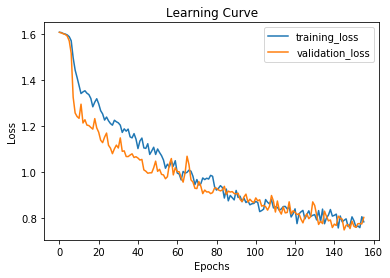

In [10]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()